<a href="https://colab.research.google.com/github/jgaomcintosh/TeamUltron/blob/main/Improving_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import requests
import os
import time
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
!sudo pip3 install keras
from tensorflow.keras.preprocessing import image
from PIL import Image as im
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# from elasticsearch import Elasticsearch
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# import tensorflow_io as tfio


In [ ]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
r = requests.get(url)
filename = '101_ObjectCategories.tar.gz'
folderdername = filename.split('.')[0]
open(filename , 'wb').write(r.content)
# reference https://stackoverflow.com/questions/30887979/i-want-to-create-a-script-for-unzip-tar-gz-file-via-python
import tarfile
if filename.endswith("tar.gz"):
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
elif filename.endswith("tar"):
    tar = tarfile.open(filename, "r:")
    tar.extractall()
    tar.close()
    
#Load Data from Google Drive 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import tarfile
import os

t = tarfile.open('101_ObjectCategories.tar.gz', 'r')
for member in t.getmembers():
    if ".jpg" in member.name:
        t.extract(member, "outdir")

print(os.listdir('outdir'))

['lfw']


To improve upon our baseline we chose to implement a the ResNet101 model, which has twice the number of layers as ResNet50. Notably, this model still uses skip connections, so increasing the number of layers does not necessarily cause vanishing gradients. Additionally we have re-compiled the model to use an Adamax optimizer rather than standard SGD. 

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adamax
img_size = 224

# create the base pre-trained model
new_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), pooling='max')

x = new_model.output

# now recompile the pre-trained model using Adamax optimizer with 0.001 learning rate
new_model.compile(optimizer=Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"))

171458560/171446536 [==============================] - 1s 0us/step


We also chose to decrease the batch size from 64 to 16, this giving our model more opportunities to update its parameters.

In [ ]:
# decreased batch size
batch_size = 16
root_dir = '/content/lfw'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode= None,
                                        shuffle=False
                                      )

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))
new_feature_list = new_model.predict(datagen, num_epochs)
print("Num images   = ", len(datagen.classes))
print("Shape of new_feature_list = ", new_feature_list.shape)

Found 13233 images belonging to 5749 classes.
Num images   =  13233
Shape of new_feature_list =  (13233, 2048)


In [ ]:
# Get full path for all the images in our dataset
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [ ]:
neighbors = NearestNeighbors(n_neighbors=20,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(new_feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=20)

In [ ]:
query_file_path= '/content/drive/MyDrive/query'
queries = os.listdir(query_file_path)

# 10 QUERY IMAGE FILE PATHS
  # /content/drive/MyDrive/query/Albert_Costa_0001.jpeg
  # /content/drive/MyDrive/query/Angela_Bassett_0001.jpeg
  # /content/drive/MyDrive/query/Arminio_Fraga_0001.jpeg
  # /content/drive/MyDrive/query/Billy_Crystal_0001.jpeg
  # /content/drive/MyDrive/query/Bob_Graham_0001.jpeg
  # /content/drive/MyDrive/query/Boris_Becker_0001.jpeg
  # /content/drive/MyDrive/query/Bulent_Ecevit_0001.jpeg
  # /content/drive/MyDrive/query/Calista_Flockhart_0001.jpeg
  # /content/drive/MyDrive/query/Cameron_Diaz_0001.jpeg
  # /content/drive/MyDrive/query/Carmen_Electra_0001.jpeg

img_path = '/content/drive/MyDrive/query/Carmen_Electra_0001.jpeg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = new_model.predict(preprocessed_img, batch_size=1)
_, indices = neighbors.kneighbors(test_img_features)


In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(4,5,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

Printing the results of our improvements, it is clear that our reverse-image search now relies less on background colors/objects and has returns images which depict more similar subjects (rather than images which appear, overall, to be generally seimilar).

(1, 20)


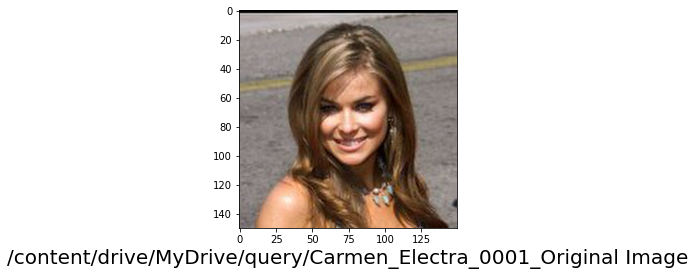

********* Predictions ***********


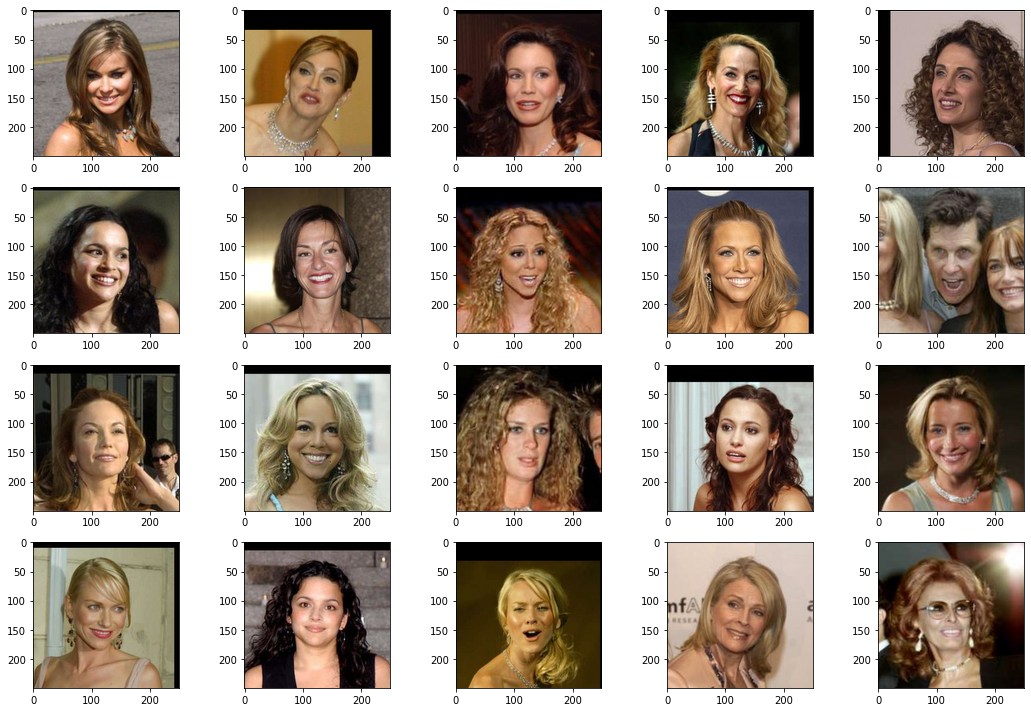

In [ ]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

We choose to not constrain the size of our feature maps for KNN fitting because, as was seen in our baseline, doing so leads to equal or worse performance of our reverse-image search.